In [7]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 95 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (95/95), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=8be0682d2442c3bac40cf3918820350818fa43e5d03729de3d61b02753efce84
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2pm2wpd/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0


In [ ]:
!pip install pyro-ppl

In [1]:
import torch
import torch.optim as optim
import torch.utils.data as Data  
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import numpy as np
import itertools
from tqdm.notebook import trange, tqdm
import torchvision

import pyro
from pyro.nn.dense_nn import ConditionalDenseNN
from pyro.distributions.transforms import permute, BatchNorm
from pyro.distributions.transforms.affine_coupling import ConditionalAffineCoupling
from pyro.infer import SVI, Trace_ELBO

from deepflows import utils
from deepflows import plot_tools
from deepflows.data_generators.halfmoon import * 

In [2]:
device=utils.set_gpu(True)
rtcs = RotatingTwoMoonsConditionalSampler()

# Load unconditional data
train_set, train_label = rtcs.conditioned_sample(1000, theta=torch.tensor([0]))
test_set, test_label = rtcs.conditioned_sample(2000, theta=torch.tensor([0]))
train_loader, test_loader = loader_half_moons(train_set, test_set, batch_size=64)


Note: GPU is available


In [10]:
def train(model, train_loader, optimizer):
  losses = []
  model.train()
  for x in train_loader:
    x = x.to(device).float()
    loss = model.nll(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  return losses

def evaluate(model, validation_loader):
  model.eval()
  total_loss=0
  n = len(validation_loader.dataset)
  with torch.no_grad():
    for x in validation_loader:
      x = x.to(device).float()
      loss = model.nll(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / n
  return avg_loss.item()

def run_model(model, train_loader, validation_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    
    #Init loss:
    test_loss = evaluate(model, validation_loader)
    test_losses.append(test_loss)  

    for epoch in tqdm(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = evaluate(model, validation_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

class MLP(nn.Module):
    def __init__(self, input_dim, n_layers, hidden_dim, output_dim):
        super(MLP, self).__init__()
        layers = []
        for _ in range(n_layers):
          layers.append(nn.Linear(input_dim, hidden_dim))
          layers.append(nn.ReLU())
          input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
      return self.layers(x)

## Autoregressive Model

In [11]:
'''
Here we make the mixtures
https://en.wikipedia.org/wiki/Mixture_model
[Batch_size, n_component, loc]
'''
class MixtureCDF(nn.Module):
    def __init__(self, n_components):
        super(MixtureCDF, self).__init__()
        self.loc = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.n_components = n_components

    def flow(self, x):
        weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1)
        # cdf of x
        z = (td.Normal(self.loc, self.log_scale.exp()).cdf(
            x.unsqueeze(1).repeat(1, self.n_components))*weights).sum(dim=1)
        # log_det = log dz/dx = log pdf(x)
        log_det = (td.Normal(self.loc, self.log_scale.exp()).log_prob(
            x.unsqueeze(1).repeat(1, self.n_components)).exp()*weights).sum(dim=1).log()
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return td.Uniform(0.0, 1.0).log_prob(z) + log_det
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return -self.log_prob(x).mean()

class AutoregFlow(nn.Module):
    def __init__(self):
        super(AutoregFlow, self).__init__()
        self.components = 5
        self.dim1_flow = MixtureCDF(n_components=self.components).to(device)
        self.mlp = MLP(1, 3, 64, self.components * 3).to(device)

    def flow(self, x):
      #split into chunks
      x1, x2 = torch.chunk(x, 2, dim=1)

      #Dimension 1, x1, find parameters
      z1, log_det1 = self.dim1_flow.flow(x1.squeeze())
      loc, log_scale, weight_logits = torch.chunk(self.mlp(x1), 3, dim=1)
      
      #Use parameters to generate z2
      weights = F.softmax(weight_logits, dim=1)
      z2 = (td.Normal(loc, log_scale.exp()).cdf(
            x2.repeat(1, self.components)) * weights).sum(dim=1)
      log_det2 = (td.Normal(loc, log_scale.exp()).log_prob(
          x2.repeat(1, self.components)).exp() * weights).sum(dim=1).log()
      
      #return z1/z2 and the determinant for the log_prob function
      return (torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), 
       torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1))

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return (td.Uniform(utils.tensor(0.0), utils.tensor(1.0)).log_prob(z) + log_det).mean(dim=1) # shape: [batch_size, dim]

    def nll(self, x):
      return - self.log_prob(x).mean()

In [5]:
ar_flow = AutoregFlow()
train_losses, test_losses = run_model(ar_flow, train_loader, test_loader, dict(epochs=100, lr=5e-3))

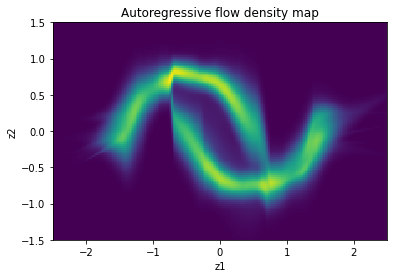

In [6]:
plot_tools.show_2d_heatmap(ar_flow.log_prob, device, title="Autoregressive flow density map")

## RealNVP Flow

In [ ]:
class AffineCoupling(nn.Module):
    def __init__(self, type, n_layers=2, hidden_dim=64):
        super(AffineCoupling, self).__init__()
        self.mask = self.create_mask(type=type)
        self.mlp = MLP(input_dim=2, n_layers=n_layers, hidden_dim=hidden_dim, output_dim=2).to(device)
    
    def create_mask(self, type):
      if type == "x_dim":
        mask = torch.FloatTensor([1.0, 0.0]).to(device)
      elif type == "y_dim":
        mask = torch.FloatTensor([0.0, 1.0]).to(device)
      else:
        print("Wrong type")
      return mask

    def forward(self, x, reverse=False):
        batch_size = x.shape[0]
        b = self.mask.repeat(batch_size, 1)
        x_mask = x * b
        output=self.mlp(x_mask)

        log_s, t = output.split(1, dim=1)

        t = t * (1.0 - b)
        log_s = log_s * (1.0 - b)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class RealNVP(nn.Module):
    def __init__(self, 
                 transforms):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.transforms = nn.ModuleList(transforms)
    
    def flow(self, x): #f
        # maps x -> z
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z): #g
        # z -> x (inverse of f)
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z)

    def nll(self, x):
        return - self.log_prob(x).mean()

In [ ]:
RNVP_flow = RealNVP([AffineCoupling("y_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("x_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("y_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("x_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("y_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("x_dim", n_layers=2, hidden_dim=64)])
train_losses, test_losses = run_model(RNVP_flow, train_loader, test_loader, dict(epochs=200, lr=5e-3))

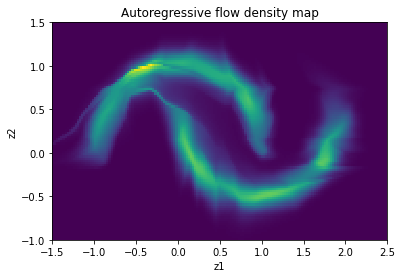

In [ ]:
plot_tools.show_2d_heatmap(RNVP_flow.log_prob, device, title="Autoregressive flow density map")

Conditional RealNVP Flow in Pyro

Credit to Daniele Gammelli: https://github.com/DanieleGammelli/pyro-torch-normalizing-flows/blob/master/ConditionalNF.ipynb

In [106]:
# Get data
x_gu = torch.zeros((10, 1000, 2))
u = torch.zeros((10, 1000, 1))
npi = np.linspace(0, 2, 10)
for i, pi in enumerate(npi):
    rtcs = RotatingTwoMoonsConditionalSampler(noise=0.05)
    x, _ = rtcs.conditioned_sample(1000, theta=torch.tensor([np.pi * pi]))
    u[i] = torch.zeros(1000,1) + i
    x_gu[i] = x

class TwoMoonData(torch.utils.data.Dataset):
    def __init__(self, x, u):
        super(TwoMoonData, self).__init__()
        self.x = x
        self.u = u
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.x[idx], self.u[idx]

dataset = TwoMoonData(x_gu.view(-1,2), u.view(-1,1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000,
                        shuffle=True, num_workers=0)

In [107]:
class ConditionalRealNVP(nn.Module):
  def __init__(self, device, input_dim = 2, split_dim = 1, context_dim = 1, hidden_dim = 64, n_layers=5, n_transforms=16):
    super(ConditionalRealNVP, self).__init__()
    #sample latent
    self.base_dist = td.Normal(torch.zeros(input_dim).to(device), torch.ones(input_dim).to(device)) #[2]
    #defining couplings. We need 1 parameter for each input_dim
    self.param_dims = [input_dim - split_dim, input_dim - split_dim]
    self.transforms = ([ConditionalAffineCoupling(split_dim, ConditionalDenseNN(split_dim, context_dim, 
                      [hidden_dim]*n_layers, self.param_dims)).to(device) for _ in range(n_transforms)])
    self.permutations = [permute(2, self.create_mask(i)) for i in range(n_transforms)]
    self.batch_norm = [BatchNorm(input_dim=1).to(device) for _ in range(n_transforms)]
    # Concatenate and unpack everything into a list, generative direction (z-->x)
    # remove last two permute and batch_norm
    self.generative_flows = list(itertools.chain(*zip(self.transforms, self.batch_norm, self.permutations)))[:-2] 
    # normalizing direction (x-->z), we reverse
    self.normalizing_flows = self.generative_flows[::-1]

  def create_mask(self, x):
    if x % 2 == 0:
      mask = torch.tensor([1, 0]).to(device)
    else:
      mask = torch.tensor([0, 1]).to(device)
    return mask

  def model(self, x=None, u=None):
    n = len(x) if x is not None else None
    pyro.module("nf", nn.ModuleList(self.transforms))
    with pyro.plate("data", n):
            self.cond_flow_dist = self.condition(u)
            obs = pyro.sample("obs", self.cond_flow_dist, obs=x)

  def condition(self, u):
    self.cond_transforms = [t.condition(u) for t in self.transforms]
    self.generative_flows = list(itertools.chain(*zip(self.cond_transforms, self.permutations)))[:-1]
    self.normalizing_flows = self.generative_flows[::-1]
    
    return TransformedDistribution(self.base_dist, self.generative_flows)

  def guide(self, x=None, u=None):
      pass
  
  def forward(self, z, u):
      zs = [z]
      _ = self.condition(u)
      for flow in self.generative_flows:
          z_i = flow(zs[-1])
          zs.append(z_i)
      return zs, z_i
  
  def backward(self, x, u):
      zs = [x]
      _ = self.condition(u)
      for flow in self.normalizing_flows:
          z_i = flow._inverse(zs[-1])
          zs.append(z_i)
      return zs, z_i
  
  def sample(self, num_samples, u):
      z_0_samples = self.base_dist.sample([num_samples])
      zs, x = self.forward(z_0_samples, u)
      return x
  
  def log_prob(self, x, u):
      cond_flow_dist = self.condition(u)
      return cond_flow_dist.log_prob(x)

In [112]:
# Initialize model
cnf=ConditionalRealNVP(device)

# TODO: make a learning rate scheduler
optimizer = pyro.optim.Adam({"lr": 0.0001})
svi = SVI(cnf.model, cnf.guide, optimizer, Trace_ELBO(num_particles=1))


In [113]:
num_epochs = 1000
losses = []
pyro.clear_param_store()
epochs = trange(num_epochs)

for epoch in epochs:
    try:
        running_loss = 0
        for x_batch, u_batch in train_loader:
            x_batch, u_batch = x_batch.to(device), u_batch.to(device)
            loss = svi.step(x_batch, u_batch)
            running_loss += float(loss)
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
    except KeyboardInterrupt:
        plt.plot(losses);
        break

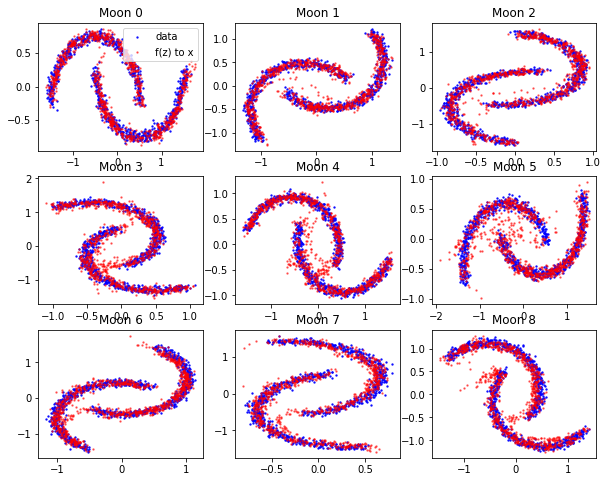

In [114]:
fig, ax = plt.subplots(3, 3, figsize=(10,8))

j=0
k=0
for i in range(3*3):
    samples = cnf.sample(num_samples=1000, u=(torch.zeros(1000, 1)+i).to(device)).detach().cpu()
    ax[k, j].scatter(x_gu[i, :, 0], x_gu[i, :, 1], c="b", label="data", alpha=0.8, s=2)
    ax[k, j].scatter(samples[:, 0], samples[:, 1], c="r", alpha=0.5, label="f(z) to x", s=2)
    ax[k, j].set_title("Moon " + str(i))
    j+=1
    if (j % 3 == 0) and (i != 0):
      j=0
      k+=1
ax[0, 0].legend();